### Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sys
import os

SCRIPT_DIR = os.path.dirname(os.path.abspath('../scripts/scripts/'))
sys.path.append(os.path.dirname(SCRIPT_DIR))

from scripts.constants import PATH_TO_DATA, DATA_FILE_NAME

### Load Dataset

In [2]:
df = pd.read_csv(os.path.join(PATH_TO_DATA, DATA_FILE_NAME), sep='|', names=['sentiment', 'review'], encoding='latin-1')
df.sample(3)

,sentiment,review
636,3,If you want to see a train wreck that you ca ...
7381,2,"Like most of Jaglom 's films , some of it is ..."
6627,2,Neither as scary-funny as Tremors nor demente...


#### About the Dataset

In [3]:
df.shape

(8544, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8544 entries, 0 to 8543
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  8544 non-null   int64 
 1   review     8544 non-null   object
dtypes: int64(1), object(1)
memory usage: 133.6+ KB


In [5]:
df.sentiment.unique()

array([4, 5, 3, 2, 1])

In [6]:
df.sentiment.value_counts()

sentiment
4    2322
2    2218
3    1624
5    1288
1    1092
Name: count, dtype: int64

In [7]:
df.sample(3)

,sentiment,review
7314,2,TV skit-com material fervently deposited on t...
7335,1,That such a horrible movie could have sprung ...
5551,3,It 's Young Guns meets Goodfellas in this eas...


### Agenda 
The purpose of this notebook is "To compare the performance of different Transformers architectures".

<b>General Approach</b>
1. Research on the different types of Transformers architectures.
2. Conduct analysis on the performance of different Transformers architectures on the given dataset.
3. Report the analysis of performance.


<b>References</b>
1. https://machinelearningmastery.com/the-transformer-model/
2. https://huggingface.co/docs/transformers/index
3. https://pytorch.org/hub/huggingface_pytorch-transformers/

#### Reseach on the different types of Transformers Architectures

There are multiple different types of Transformers Architectures available in the open source market now. With a myriad of options to choose from, one can only decide which one to use based on the performance of the Transformers architecture on the given dataset. In this notebook, I will be exploring the use of Transformers (and their pretrained model weights) to perform sentiment analysis on the given dataset.

I will be using the `pytorch-transformers` package to implement the models. In this package, there are a total of 8 pretrained models to choose from.
- BERT (from Google) released with the paper BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding by Jacob Devlin, Ming-Wei Chang, Kenton Lee and Kristina Toutanova.
- GPT (from OpenAI) released with the paper Improving Language Understanding by Generative Pre-Training by Alec Radford, Karthik Narasimhan, Tim Salimans and Ilya Sutskever.
- GPT-2 (from OpenAI) released with the paper Language Models are Unsupervised Multitask Learners by Alec Radford, Jeffrey Wu, Rewon Child, David Luan, Dario Amodei** and Ilya Sutskever**.
- Transformer-XL (from Google/CMU) released with the paper Transformer-XL: Attentive Language Models Beyond a Fixed-Length Context by Zihang Dai, Zhilin Yang, Yiming Yang, Jaime Carbonell, Quoc V. Le, Ruslan Salakhutdinov.
- XLNet (from Google/CMU) released with the paper ​XLNet: Generalized Autoregressive Pretraining for Language Understanding by Zhilin Yang, Zihang Dai, Yiming Yang, Jaime Carbonell, Ruslan Salakhutdinov, Quoc V. Le.
- XLM (from Facebook) released together with the paper Cross-lingual Language Model Pretraining by Guillaume Lample and Alexis Conneau.
- RoBERTa (from Facebook), released together with the paper a Robustly Optimized BERT Pretraining Approach by Yinhan Liu, Myle Ott, Naman Goyal, Jingfei Du, Mandar Joshi, Danqi Chen, Omer Levy, Mike Lewis, Luke Zettlemoyer, Veselin Stoyanov.
- DistilBERT (from HuggingFace), released together with the blogpost Smaller, faster, cheaper, lighter: Introducing DistilBERT, a distilled version of BERT by Victor Sanh, Lysandre Debut and Thomas Wolf.

##### Implementing BERT for Sentiment Analysis
Reference: https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/6%20-%20Transformers%20for%20Sentiment%20Analysis.ipynb and https://huggingface.co/docs/transformers/main_classes/pipelines

In [8]:
from transformers import AutoTokenizer, pipeline, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from sklearn.model_selection import train_test_split
import numpy as np
import evaluate
from string import punctuation

from huggingface_hub.hf_api import HfFolder
HfFolder.save_token('')

/Users/peanutsee/Desktop/Year 4 Sem 1/CZ4042 - Neural Network & Deep Learning/Group Project/pyenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# Define BERT Model
bert = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [11]:
# Initialise tokenizer for BERT uncased
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']
print(max_input_length)

512


In [12]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

<Axes: xlabel='n_tokens'>

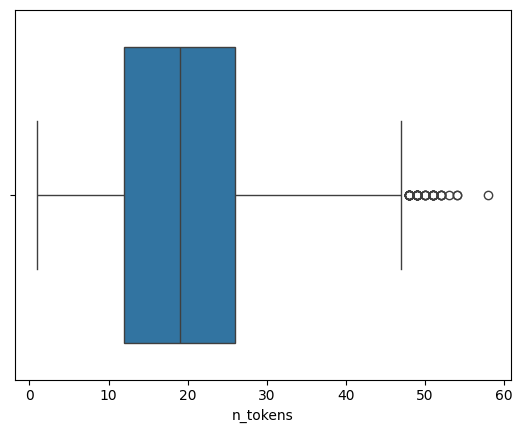

In [13]:
# Determine the maximum number of possible tokens
df_copy = df.copy()

# Define pre-processing function (remove numbers and punctuations)
def preprocess_text(text:str) -> str:
    # Case text to lower case
    text_lowercase = text.lower()
    
    # Strip whitespaces
    text_no_ws = " ".join([x for x in text_lowercase.split(" ") if x != " "])
    
    # Remove punctuation
    text_no_punc = ''.join([x for x in text_no_ws if x not in punctuation])
    
    # Remove numbers
    text_no_num = ''.join([x for x in text_no_punc if x.isalpha() or x == " "])
    
    return text_no_num.strip()

df_copy['review_cleaned'] = df_copy['review'].apply(preprocess_text)


# Count number of tokens
df_copy['n_tokens'] = df_copy['review_cleaned'].apply(lambda x: len(tokenizer.tokenize(x)))

# Display counts for tokens
sns.boxplot(data=df_copy, x='n_tokens')

In [14]:
n_tokens_max, n_tokens_min = df_copy['n_tokens'].max(), df_copy['n_tokens'].min()
print(f'Max: {n_tokens_max}\nMin: {n_tokens_min}')

Max: 58
Min: 1


In [15]:
reviews = list(map(preprocess_text, df['review']))
labels = list(df['sentiment'])

In [16]:
dataset = []
for review, label in zip(reviews, labels):
    dataset.append({"text": review, "label": str(label)})

In [17]:
train, test = train_test_split(dataset, test_size=0.25)

In [18]:
def preprocess_function(examples):
    return {
        "text": examples['text'],
        "label": int(examples['label']),
        **tokenizer(examples["text"], truncation=True)
    }

tokenized_train= list(map(preprocess_function, train))
tokenized_test= list(map(preprocess_function, test))

In [19]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [20]:
accuracy = evaluate.load("accuracy")

In [21]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [22]:
training_args = TrainingArguments(
    output_dir="bert_uncased_trained",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
)

trainer = Trainer(
    model=bert,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  0%|          | 0/505 [00:00<?, ?it/s]You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
                                                 
 20%|██        | 101/505 [01:02<04:26,  1.52it/s]

{'eval_loss': 0.9147855639457703, 'eval_accuracy': 0.43913857677902624, 'eval_runtime': 5.5543, 'eval_samples_per_second': 384.568, 'eval_steps_per_second': 6.121, 'epoch': 1.0}


                                                 
 40%|████      | 202/505 [02:06<02:48,  1.79it/s]

{'eval_loss': 0.870308518409729, 'eval_accuracy': 0.4559925093632959, 'eval_runtime': 5.2155, 'eval_samples_per_second': 409.547, 'eval_steps_per_second': 6.519, 'epoch': 2.0}


                                                 
 60%|██████    | 303/505 [03:09<01:29,  2.27it/s]

{'eval_loss': 0.8513351678848267, 'eval_accuracy': 0.47659176029962547, 'eval_runtime': 5.1448, 'eval_samples_per_second': 415.173, 'eval_steps_per_second': 6.609, 'epoch': 3.0}


                                                 
 80%|████████  | 404/505 [04:13<00:42,  2.36it/s]

{'eval_loss': 0.902057409286499, 'eval_accuracy': 0.4789325842696629, 'eval_runtime': 5.6416, 'eval_samples_per_second': 378.613, 'eval_steps_per_second': 6.027, 'epoch': 4.0}


 99%|█████████▉| 500/505 [05:16<00:02,  1.72it/s]

{'loss': 0.752, 'learning_rate': 1.9801980198019803e-07, 'epoch': 4.95}


                                                 
100%|██████████| 505/505 [05:26<00:00,  1.94it/s]

{'eval_loss': 0.9106379151344299, 'eval_accuracy': 0.4798689138576779, 'eval_runtime': 7.0588, 'eval_samples_per_second': 302.6, 'eval_steps_per_second': 4.817, 'epoch': 5.0}


100%|██████████| 505/505 [05:29<00:00,  1.53it/s]


{'train_runtime': 329.2955, 'train_samples_per_second': 97.299, 'train_steps_per_second': 1.534, 'train_loss': 0.7494500264082805, 'epoch': 5.0}


TrainOutput(global_step=505, training_loss=0.7494500264082805, metrics={'train_runtime': 329.2955, 'train_samples_per_second': 97.299, 'train_steps_per_second': 1.534, 'train_loss': 0.7494500264082805, 'epoch': 5.0})

In [24]:
text = 'my kukubird is very big!! omg!! I love it!!'

classifier = pipeline("sentiment-analysis", model="./bert_uncased_trained/")
classifier(text)

[{'label': 'LABEL_4', 'score': 0.9299127459526062}]